In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
from oracle_w_fuzzy import load_data
import pandas as pd

In [15]:
# from sklearn.datasets import load_breast_cancer
# data = load_breast_cancer(as_frame=True)

In [200]:
from h1st.model.predictive_model import PredictiveModel

class RuleModel(PredictiveModel):
    sepal_length_max: float = 5.3
    sepal_length_min: float = 3.7
    sepal_width_max: float = 4.4
    sepal_width_min: float = 3
    
    def predict(self, data):
        df = data['x']
        return {'predictions': pd.DataFrame(
            map(self.predict_setosa, df['sepal_length'], df['sepal_width']), 
            columns=['setosa'])}

    def predict_setosa(self, sepal_length, sepal_width):
        return 1 if (self.sepal_length_min <= sepal_length <= self.sepal_length_max) \
                  & (self.sepal_width_min <= sepal_width <= self.sepal_width_max) \
               else 0

In [209]:
import numpy as np
from h1st.model.fuzzy import (
    FuzzyVariables,
    FuzzyMembership as fm,
    FuzzyRules,
    FuzzyModeler
)

def get_meta_data(data):
    res = {}
    for k, v in data.max().to_dict().items():
        res[k] = {'max': v}
    for k, v in data.min().to_dict().items():
        res[k].update({'min': v})    
    return res

def create_fuzzy_model(data):
    meta_data = get_meta_data(data)
    fuzzy_vars = FuzzyVariables()
    fuzzy_vars.add(
        var_name='sepal_length',
        var_type='antecedent',
        var_range=np.arange(
            meta_data['sepal_length']['min'], 
            meta_data['sepal_length']['max'], 
            0.1
        ),
        membership_funcs=[('small', fm.SIGMOID, [5.3, -2.5]),
                            ('large', fm.SIGMOID, [5.3, 2.5])]
    )
    fuzzy_vars.add(
        var_name='sepal_width',
        var_type='antecedent',
        var_range=np.arange(
            meta_data['sepal_width']['min'], 
            meta_data['sepal_width']['max'], 
            0.1
        ),
        membership_funcs=[('small', fm.SIGMOID, [3.1, -2.0]),
                            ('large', fm.SIGMOID, [3.1, 2.0])]
    )
    fuzzy_vars.add(
        var_name='setosa',
        var_type='consequent',
        var_range=np.arange(0, 1+1e-5, 0.1),
        membership_funcs=[('false', fm.GAUSSIAN, [0, 0.5]),
                        ('true', fm.GAUSSIAN, [1, 0.5])]
    )

    fuzzy_rule = FuzzyRules()
    fuzzy_rule.add(
        'rule1',
        if_term=fuzzy_vars.get('sepal_length')['small'] & fuzzy_vars.get('sepal_width')['large'],
        then_term=fuzzy_vars.get('setosa')['true']
    )
    fuzzy_rule.add(
        'rule2',
        if_term=fuzzy_vars.get('sepal_length')['large'] & fuzzy_vars.get('sepal_width')['small'],
        then_term=fuzzy_vars.get('setosa')['false']
    )

    modeler = FuzzyModeler()
    teacher = modeler.build_model(fuzzy_vars, fuzzy_rule)
    return teacher

In [210]:
from sklearn import datasets

In [211]:
df_raw = datasets.load_iris(as_frame=True).frame
df_raw.columns = [
    "sepal_length",
    "sepal_width",
    "petal_length",
    "petal_width",
    "setosa",
]
df_raw = df_raw[[
    "sepal_length",
    "sepal_width",
    "setosa"]]
df_raw["setosa"] = df_raw["setosa"].apply(lambda x: 1 if x == 0 else 0)

In [212]:
df_raw["setosa"].value_counts()

0    100
1     50
Name: setosa, dtype: int64

In [213]:
# fuzzy_teacher = create_fuzzy_model(df_raw)
# fuzzy_teacher.visualize_variables()

In [226]:
# scikit-learn k-fold cross-validation
from collections import defaultdict
from numpy import array
from sklearn.model_selection import KFold
from h1st.model.oracle import OracleModeler
from h1st.model.oracle.ensemble import GradBoostEnsembleModeler

# prepare cross validation
kfold = KFold(n_splits=3, shuffle=True, random_state=1)

all_metrics = defaultdict(lambda: defaultdict(list))
all_index = defaultdict(lambda: defaultdict(list))

# 1. build rule-based model
bool_teacher = RuleModel()
fuzzy_teacher = create_fuzzy_model(df_raw)

# enumerate splits
for no, data_idx in enumerate(kfold.split(df_raw)):
    train, test = data_idx
    # 2. prepare data
    df_train, df_test = df_raw.iloc[train], df_raw.iloc[test]
    input_data = {
        "unlabeled_data": df_train[["sepal_length", "sepal_width"]],
        "labeled_data": {
            "x_train": df_train[["sepal_length", "sepal_width"]],
            "y_train": df_train[["setosa"]],
            "x_test": df_test[["sepal_length", "sepal_width"]],
            "y_test": df_test[["setosa"]],
        },
    }

    # 3. build oracle
    # 3.1 bool
    modeler = OracleModeler()
    oracle_with_bool = modeler.build_model(
        data=input_data,
        teacher=bool_teacher)
    
    # 3.2 fuzzy
    fuzzy_thresholds = {'setosa': 0.55}
    oracle_with_fuzzy = modeler.build_model(
        data=input_data,
        teacher=fuzzy_teacher,
        fuzzy_thresholds=fuzzy_thresholds)

    # 3.3 bool + ml_ensemble
    oracle_with_bool_ml = modeler.build_model(
        data=input_data, 
        teacher=bool_teacher,
        ensembler_modeler=GradBoostEnsembleModeler())

    # 3.4 fuzzy + ml_ensemble
    fuzzy_thresholds = {'setosa': 0.55}
    oracle_with_fuzzy_ml = modeler.build_model(
        data=input_data, 
        teacher=fuzzy_teacher,
        fuzzy_thresholds=fuzzy_thresholds,
        ensembler_modeler=GradBoostEnsembleModeler()) 

    # 3.5 bool + ml_ensemble + x
    oracle_with_bool_ml_x = modeler.build_model(
        data=input_data, 
        teacher=bool_teacher,
        ensembler_modeler=GradBoostEnsembleModeler(),
        inject_x_in_ensembler=True)

    # 3.6 fuzzy + ml_ensemble + x
    fuzzy_thresholds = {'setosa': 0.55}
    oracle_with_fuzzy_ml_x = modeler.build_model(
        data=input_data, 
        teacher=fuzzy_teacher,
        fuzzy_thresholds=fuzzy_thresholds,
        ensembler_modeler=GradBoostEnsembleModeler(),
        inject_x_in_ensembler=True) 

    model_map = {
        "oracle_with_bool": oracle_with_bool,
        "oracle_with_fuzzy": oracle_with_fuzzy,
        "oracle_with_bool_ml": oracle_with_bool_ml,
        "oracle_with_fuzzy_ml": oracle_with_fuzzy_ml,
        "oracle_with_bool_ml_x": oracle_with_bool_ml_x,
        "oracle_with_fuzzy_ml_x": oracle_with_fuzzy_ml_x,        
    }

    # 4. collect evaluation results
    for name, oracle in model_map.items():
        for metrics in ['f1_score', 'precision', 'recall']:
            temp = oracle.metrics[metrics]['setosa']
            s1, s2 = temp.pop('students')
            temp.update({'student1': s1, 'student2': s2})
            all_metrics[metrics][name].append(temp)
            all_index[metrics][name].append(f'{name}_{no}')

(100, 2)


INFO:root:Evaluated all sub models successfully.
INFO:root:Evaluated all sub models successfully.
INFO:root:Evaluated all sub models successfully.
INFO:root:Evaluated all sub models successfully.
INFO:root:Evaluated all sub models successfully.
INFO:root:Evaluated all sub models successfully.


(100, 2)


INFO:root:Evaluated all sub models successfully.
INFO:root:Evaluated all sub models successfully.
INFO:root:Evaluated all sub models successfully.
INFO:root:Evaluated all sub models successfully.
INFO:root:Evaluated all sub models successfully.
INFO:root:Evaluated all sub models successfully.
INFO:root:Evaluated all sub models successfully.


(100, 2)


INFO:root:Evaluated all sub models successfully.
INFO:root:Evaluated all sub models successfully.
INFO:root:Evaluated all sub models successfully.
INFO:root:Evaluated all sub models successfully.
INFO:root:Evaluated all sub models successfully.


In [219]:
input_data['labeled_data']['x_train'].dropna().shape

(100, 2)

In [221]:
input_data['labeled_data']['x_test'].dropna().shape

(50, 2)

In [215]:
all_avg_metrics = []
oracle_names = []
for metrics_type in ['f1_score', 'precision', 'recall']:
    for oracle_name, metrics in all_metrics[metrics_type].items():
        df_metrics = pd.DataFrame(metrics)
        # print(metrics_type, oracle_name, df_metrics.mean().values)
        all_avg_metrics.append(
            [metrics_type] + list(df_metrics.mean().values)
        )
        oracle_names.append(oracle_name)

final_metrics = pd.DataFrame(
    all_avg_metrics,
    columns=['metrics_type', 'teacher', 'ensemblers', 'student1', 'student2'],
    index=oracle_names
)

final_metrics

,metrics_type,teacher,ensemblers,student1,student2
oracle_with_bool,f1_score,0.863713,0.874360,0.874360,0.935007
oracle_with_fuzzy,f1_score,0.866383,0.887653,0.887653,0.946387
oracle_with_bool,precision,1.000000,1.000000,1.000000,1.000000
oracle_with_fuzzy,precision,1.000000,1.000000,1.000000,1.000000
oracle_with_bool,recall,0.764557,0.782103,0.782103,0.878077
oracle_with_fuzzy,recall,0.766620,0.805913,0.805913,0.899823


In [68]:
oracle_with_fuzzy.metrics

{'f1_score': {'setosa': {'teacher': 0.82927,
   'students': [0.82927, 0.95],
   'ensemblers': 0.94444}},
 'precision': {'setosa': {'teacher': 0.77273,
   'students': [0.77273, 0.90476],
   'ensemblers': 1.0}},
 'recall': {'setosa': {'teacher': 0.89474,
   'students': [0.89474, 1.0],
   'ensemblers': 0.89474}}}

In [37]:
import plotly.graph_objects as go
#adding figure for Length/Width visualization
fig1=go.Figure()
#adding traces
fig1.add_trace(go.Scatter(x=df_raw[df_raw.setosa == 1].sepal_width, y=df_raw[df_raw.setosa == 1].sepal_length, name='Setosa',
                        mode='markers', marker_color='rgb(52, 152, 219)',
                        marker_symbol='star-triangle-up', marker_opacity=0.8,
                        hovertemplate="<b>SepalWidthCm:</b> %{x} <br><b>SepalLengthCm:</b> %{y}"))
fig1.add_trace(go.Scatter(x=df_raw[df_raw.setosa != 1].sepal_width, y=df_raw[df_raw.setosa != 1].sepal_length, name='Non-Setosa',
                        mode='markers', marker_color='rgb(170, 128, 255)',
                        marker_symbol='hexagram', marker_opacity=0.8,
                        hovertemplate="<b>SepalWidthCm:</b> %{x} <br><b>SepalLengthCm:</b> %{y}"))

#customizing figure
fig1.update_traces(mode='markers', marker_line_width=1.5, marker_size=12)
fig1.update_layout(template='plotly_white', xaxis=dict(title_text='SepalWidthCm', title_standoff=10),
                   yaxis=dict(title_text='SepalLengthCm', title_standoff=10),
                   title_text='Sepal Length/Width', title_x=0.5)
fig1.update_xaxes(showline=True, linewidth=3, linecolor='black',
                  showspikes=True, spikecolor='red', spikethickness=2)
fig1.update_yaxes(showline=True, linewidth=3, linecolor='black',
                  showspikes=True, spikecolor='red', spikethickness=2)
#showing figure
fig1.show()

In [ ]:
sepal_length_max: float = 5.3
sepal_length_min: float = 3.7
sepal_width_max: float = 4.4
sepal_width_min: float = 3.1

In [16]:
# Using plotly.express
import plotly.express as px

fig = px.line(teacher_pred)
fig.show()

In [17]:
teacher_pred.head()

,setosa,non_setosa
0,0.665,0.335
1,0.467,0.533
2,0.326,0.674
3,0.500,0.500
4,0.502,0.498


In [18]:
from sklearn import metrics
output = list(map(lambda x: 1 if x > 0.6 else 0, teacher_pred['setosa']))
# temp = teacher.predict(data['training_data'])['predictions']
metrics.accuracy_score(output, data['labeled_data']['y_train'])

0.8777777777777778

In [19]:
from sklearn import metrics
output = list(map(lambda x: 1 if x > 0.49 else 0, teacher_pred['non_setosa']))
# temp = teacher.predict(data['training_data'])['predictions']
y_true = data['labeled_data']['y_train'].apply(lambda x: x ^ 1).rename('non_setosa')
metrics.accuracy_score(output, y_true)

0.8111111111111111

In [20]:
rule_model = RuleModel()

In [21]:
temp = rule_model.predict({'x': data['labeled_data']['x_train']})['predictions']
metrics.accuracy_score(temp, data['labeled_data']['y_train'])

0.9

In [22]:
data['labeled_data']['y_train'] = pd.concat(
    [data['labeled_data']['y_train'].rename('setosa'), 
    data['labeled_data']['y_train'].apply(lambda x: x ^ 1).rename('non_setosa')], 
    axis=1
)

In [23]:
data['labeled_data']['y_test'] = pd.concat(
    [data['labeled_data']['y_test'].rename('setosa'), 
    data['labeled_data']['y_test'].apply(lambda x: x ^ 1).rename('non_setosa')], 
    axis=1
)

In [24]:
from h1st.model.oracle import OracleModeler
modeler = OracleModeler()

In [26]:
fuzzy_thresholds = {'setosa': 0.6, 'non_setosa': 0.49}

oracle = modeler.build_model(
    data=data, 
    teacher=teacher,
    fuzzy_thresholds=fuzzy_thresholds)

INFO:root:Evaluated all sub models successfully.


In [27]:
fuzzy_thresholds = {'setosa': 0.6, 'non_setosa': 0.49}

oracle = modeler.build_model(
    data={'unlabeled_data': data['unlabeled_data']}, 
    teacher=teacher,
    fuzzy_thresholds=fuzzy_thresholds)

In [28]:
test_data = {'x': data['labeled_data']['x_test']}
prediction = oracle.predict(test_data)

In [29]:
oracle.metrics

{}

In [30]:
oracle2 = modeler.build_model(
    data=data, 
    teacher=rule_model)

test_data = {'x': data['labeled_data']['x_test']}
prediction = oracle2.predict(test_data)

INFO:root:Evaluated all sub models successfully.


In [31]:
oracle2.metrics

{'accuracy': {'setosa': {'teacher': 0.86667,
   'students': [0.86667, 0.91667],
   'ensemblers': 0.86667}},
 'precision': {'setosa': {'teacher': 0.72,
   'students': [0.72, 0.79167],
   'ensemblers': 0.72}},
 'recall': {'setosa': {'teacher': 0.94737,
   'students': [0.94737, 1.0],
   'ensemblers': 0.94737}}}

In [32]:
from h1st.model.oracle.ensemble import GradBoostEnsembleModeler

In [33]:
oracle3 = modeler.build_model(
    data=data, 
    teacher=rule_model,
    ensembler_modeler=GradBoostEnsembleModeler())

test_data = {'x': data['labeled_data']['x_test']}
prediction = oracle3.predict(test_data)

INFO:root:Evaluated all sub models successfully.


In [34]:
oracle3.ensemblers

{'setosa': <h1st.model.oracle.ensemble.GradBoostEnsemble at 0x7fc079c17850>}

In [35]:
oracle3.metrics

{'accuracy': {'setosa': {'teacher': 0.86667,
   'students': [0.86667, 0.91667],
   'ensemblers': 0.98333}},
 'precision': {'setosa': {'teacher': 0.72,
   'students': [0.72, 0.79167],
   'ensemblers': 1.0}},
 'recall': {'setosa': {'teacher': 0.94737,
   'students': [0.94737, 1.0],
   'ensemblers': 0.94737}}}

In [36]:
fuzzy_thresholds = {'setosa': 0.6, 'non_setosa': 0.49}
oracle4 = modeler.build_model(
    data=data, 
    teacher=teacher,
    fuzzy_thresholds=fuzzy_thresholds,
    ensembler_modeler=GradBoostEnsembleModeler())

test_data = {'x': data['labeled_data']['x_test']}
prediction = oracle4.predict(test_data)

INFO:root:Evaluated all sub models successfully.


In [37]:
oracle4.metrics

{'accuracy': {'setosa': {'teacher': 0.83333,
   'students': [0.9, 0.93333],
   'ensemblers': 0.95},
  'non_setosa': {'teacher': 0.81667,
   'students': [0.83333, 0.95],
   'ensemblers': 1.0}},
 'precision': {'setosa': {'teacher': 0.73684,
   'students': [0.88235, 0.94118],
   'ensemblers': 0.94444},
  'non_setosa': {'teacher': 0.91667,
   'students': [0.94286, 1.0],
   'ensemblers': 1.0}},
 'recall': {'setosa': {'teacher': 0.73684,
   'students': [0.78947, 0.84211],
   'ensemblers': 0.89474},
  'non_setosa': {'teacher': 0.80488,
   'students': [0.80488, 0.92683],
   'ensemblers': 1.0}}}

In [38]:
prediction

{'predictions': {'setosa': array([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]),
  'non_setosa': array([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
         1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0])}}

In [39]:
import os
path = '/Users/aitomatic/src/github/h1st-ai/h1st/user/example-models/oracle/model_repo'
os.environ['H1ST_MODEL_REPO_PATH'] = path

In [40]:
oracle4.persist('test_ml_ensemble_oracle')

INFO:h1st.model.repository.model_repository:Saving stats property...
INFO:h1st.model.repository.model_repository:Saving model property...
INFO:h1st.model.repository.model_repository:Saving stats property...
INFO:h1st.model.repository.model_repository:Saving model property...
INFO:h1st.model.repository.model_repository:Saving metrics property...
INFO:h1st.model.repository.model_repository:Saving stats property...
INFO:h1st.model.repository.model_repository:Saving model property...
INFO:h1st.model.repository.model_repository:Saving stats property...
INFO:h1st.model.repository.model_repository:Saving model property...
INFO:h1st.model.repository.model_repository:Saving stats property...
INFO:h1st.model.repository.model_repository:Saving model property...
INFO:h1st.model.repository.model_repository:Saving metrics property...
INFO:h1st.model.repository.model_repository:Saving stats property...
INFO:h1st.model.repository.model_repository:Saving model property...
INFO:h1st.model.repository.mod

'test_ml_ensemble_oracle'

In [41]:
oracle4.stats

{'fuzzy_thresholds': {'setosa': 0.6, 'non_setosa': 0.49},
 'features': None,
 'inject_x_in_ensembler': False,
 'labels': ['setosa', 'non_setosa'],
 'model_details': {'teacher_details': {'class': h1st.model.fuzzy.fuzzy_model.FuzzyModel,
   'version': 'teacher_test_ml_ensemble_oracle'},
  'student_details': {'setosa': {'class': [h1st.model.oracle.student.RandomForestModel,
     h1st.model.oracle.student.LogisticRegressionModel],
    'version': ['student_test_ml_ensemble_oracle_setosa_0',
     'student_test_ml_ensemble_oracle_setosa_1']},
   'non_setosa': {'class': [h1st.model.oracle.student.RandomForestModel,
     h1st.model.oracle.student.LogisticRegressionModel],
    'version': ['student_test_ml_ensemble_oracle_non_setosa_0',
     'student_test_ml_ensemble_oracle_non_setosa_1']}},
  'ensembler_details': {'setosa': {'class': h1st.model.oracle.ensemble.GradBoostEnsemble,
    'version': 'ensembler_test_ml_ensemble_oracle_setosa'},
   'non_setosa': {'class': h1st.model.oracle.ensemble.Grad

In [42]:
oracle4 = None

In [43]:
from h1st.model.oracle import Oracle
oracle4 = Oracle()
oracle4.load('test_ml_ensemble_oracle')

INFO:h1st.model.repository.model_repository:Loading version test_ml_ensemble_oracle ....
INFO:h1st.model.repository.model_repository:Loading version teacher_test_ml_ensemble_oracle ....
INFO:h1st.model.repository.model_repository:Loading version ensembler_test_ml_ensemble_oracle_setosa ....
INFO:h1st.model.repository.model_repository:Loading version student_test_ml_ensemble_oracle_setosa_0 ....
INFO:h1st.model.repository.model_repository:Loading version student_test_ml_ensemble_oracle_setosa_1 ....
INFO:h1st.model.repository.model_repository:Loading version ensembler_test_ml_ensemble_oracle_non_setosa ....
INFO:h1st.model.repository.model_repository:Loading version student_test_ml_ensemble_oracle_non_setosa_0 ....
INFO:h1st.model.repository.model_repository:Loading version student_test_ml_ensemble_oracle_non_setosa_1 ....


In [44]:
oracle4.stats['model_details']

{'teacher_details': {'class': h1st.model.fuzzy.fuzzy_model.FuzzyModel,
  'version': 'teacher_test_ml_ensemble_oracle'},
 'student_details': {'setosa': {'class': [h1st.model.oracle.student.RandomForestModel,
    h1st.model.oracle.student.LogisticRegressionModel],
   'version': ['student_test_ml_ensemble_oracle_setosa_0',
    'student_test_ml_ensemble_oracle_setosa_1']},
  'non_setosa': {'class': [h1st.model.oracle.student.RandomForestModel,
    h1st.model.oracle.student.LogisticRegressionModel],
   'version': ['student_test_ml_ensemble_oracle_non_setosa_0',
    'student_test_ml_ensemble_oracle_non_setosa_1']}},
 'ensembler_details': {'setosa': {'class': h1st.model.oracle.ensemble.GradBoostEnsemble,
   'version': 'ensembler_test_ml_ensemble_oracle_setosa'},
  'non_setosa': {'class': h1st.model.oracle.ensemble.GradBoostEnsemble,
   'version': 'ensembler_test_ml_ensemble_oracle_non_setosa'}}}

In [45]:
oracle4.students

defaultdict(list,
            {'setosa': [<h1st.model.oracle.student.RandomForestModel at 0x7fc0a1344640>,
             'non_setosa': [<h1st.model.oracle.student.RandomForestModel at 0x7fc0714531f0>,
              <h1st.model.oracle.student.LogisticRegressionModel at 0x7fc079c14190>]})

In [46]:
test_data = {'x': data['labeled_data']['x_train']}
prediction_from_loaded = oracle4.predict(test_data)

In [47]:
prediction_from_loaded

{'predictions': {'setosa': array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
         0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
         1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
         0, 1]),
  'non_setosa': array([0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
         1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
         0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
         1, 0])}}

## Evaluation of Oracle with Azure IoT dataset

In [48]:
import pandas as pd 

In [49]:
# you can download the data from kaggle using the following link.
# https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance

dir_path = '/Users/aitomatic/Desktop/dataset/azure_iot'
path = f'{dir_path}/'
telemetry_url = 'PdM_telemetry.csv'
df = pd.read_csv(path + 'PdM_telemetry.csv')
df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])
df.loc[:, 'datetime'] = df['datetime'] - pd.Timedelta(hours=6)
df_machines = pd.read_csv(path + 'PdM_machines.csv')
df = df.join(df_machines.set_index('machineID'), on='machineID')
df.loc[:, 'date'] = df['datetime'].dt.date

In [50]:
df.model.value_counts()

model3    306635
model4    280352
model2    148937
model1    140176
Name: model, dtype: int64

In [51]:
df_failures = pd.read_csv(path + 'PdM_failures.csv')
df_failures.shape

(761, 3)

In [52]:
for model_type in ['model1', 'model2', 'model3', 'model4']:
    id_list = df[df.model == model_type].machineID.unique()
    print(f'{model_type} failure records:', df_failures[df_failures.machineID.isin(id_list)].shape)

model1 failure records: (189, 3)
model2 failure records: (168, 3)
model3 failure records: (221, 3)
model4 failure records: (183, 3)


### model3 has the largest number of data and labels. For now, let's only use Model3 data for evaluation.

In [53]:
df_model3 = df[df.model=='model3']
df_model3.shape

(306635, 9)

In [54]:
df_model3.machineID.nunique()

35

In [55]:
df_model3_failures = df_failures[df_failures.machineID.isin(df_model3.machineID.unique())]
df_model3_failures.shape

(221, 3)

In [56]:
df_model3_daily = df_model3.groupby(['date', 'machineID']).agg('mean')

In [57]:
# We will use these values as threshold value of boolean rule (98 percentile)
percentile = 0.96
print('volt:', df_model3_daily['volt'].quantile(percentile))
print('rotate:', df_model3_daily['rotate'].quantile(1-percentile))
print('vibration:', df_model3_daily['vibration'].quantile(percentile))

volt: 179.45791154625303
rotate: 404.7505991485843
vibration: 44.35954992950687


In [58]:
df_model3_daily.describe()

,volt,rotate,pressure,vibration,age
count,12810.000000,12810.000000,12810.000000,12810.000000,12810.000000
mean,170.814333,446.486156,100.676527,40.399771,12.028571
std,4.844358,18.628207,4.420372,2.116506,5.526701
min,134.008631,274.902422,83.252434,32.154524,1.000000
25%,168.025315,441.602970,98.662233,39.365385,8.000000
50%,170.229576,449.271656,100.044740,40.066996,14.000000
75%,172.493540,456.233763,101.542986,40.823996,17.000000
max,211.548400,551.314893,152.660905,60.994016,20.000000


In [59]:
# Remove 2016-01-01 because machine has only one hour data on this date.

import datetime

df_model3 = df_model3[df_model3.date != datetime.datetime(2016, 1, 1).date()]
df_model3.shape

(306600, 9)

In [60]:
# Split the entire dataset into Training and Test datasets with split_ratio 3:2

import numpy as np

test_ratio = 0.4
n_split = int(df_model3.machineID.nunique() * test_ratio)
model3_ids = df_model3.machineID.unique()
rng = np.random.default_rng(42)
rng.shuffle(model3_ids)

model3_ids_for_train = model3_ids[n_split:]
model3_ids_for_test = model3_ids[:n_split]

df_model3_train = df_model3[df_model3.machineID.isin(model3_ids_for_train)]
df_model3_test = df_model3[df_model3.machineID.isin(model3_ids_for_test)]
print(df_model3_train.shape, df_model3_test.shape)

(183960, 9) (122640, 9)


In [61]:
keys = ['machineID', 'date']
features = ['volt', 'rotate', 'pressure', 'vibration']

In [62]:
temp_gb = df_model3_train.groupby(keys)
list_of_train_daily = [item for item in temp_gb]

temp_gb = df_model3_test.groupby(keys)
list_of_test_daily = [item for item in temp_gb]

print(f'number of data points in train dataset: {len(list_of_train_daily)}')
print(f'number of data points in test dataset: {len(list_of_test_daily)}')

number of data points in train dataset: 7665
number of data points in test dataset: 5110


In [63]:
"""
From the above EDA, we found that failures can be detected one~two days earlier than 
the recorded date of failure and it is also reasonable to say that there is a one day 
gap between machine failed date and repair date. So, we will use (recorded repair date - 1 day) 
as a ground truth date of machine failure.
"""
from datetime import timedelta
df_model3_failures['datetime'] = pd.to_datetime(df_model3_failures['datetime'])
df_model3_failures['date'] = df_model3_failures['datetime'].apply(lambda x: x.date())
df_model3_failures['date_1'] = df_model3_failures['date'] - timedelta(days=1)

/var/folders/wb/40304xlx477cfjzbk386l2gr0000gn/T/ipykernel_49768/2163752014.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/wb/40304xlx477cfjzbk386l2gr0000gn/T/ipykernel_49768/2163752014.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/wb/40304xlx477cfjzbk386l2gr0000gn/T/ipykernel_49768/2163752014.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [64]:
df_model3_failures.failure.value_counts()

comp2    89
comp1    68
comp4    64
Name: failure, dtype: int64

In [65]:
df_model3_failures[(df_model3_failures.machineID==1)]

,datetime,machineID,failure,date,date_1
0,2015-01-05 06:00:00,1,comp4,2015-01-05,2015-01-04
1,2015-03-06 06:00:00,1,comp1,2015-03-06,2015-03-05
2,2015-04-20 06:00:00,1,comp2,2015-04-20,2015-04-19
3,2015-06-19 06:00:00,1,comp4,2015-06-19,2015-06-18
4,2015-09-02 06:00:00,1,comp4,2015-09-02,2015-09-01
5,2015-10-17 06:00:00,1,comp2,2015-10-17,2015-10-16
6,2015-12-16 06:00:00,1,comp4,2015-12-16,2015-12-15


In [66]:
# Generate ground truth label for train and test datasets. 
# In some failure cases, one machine can have n number of faulty components and, 
# in that case, we generated n data points with n different kinds of labels.

In [67]:
column_values = []
for idx in range(24):
    column_values.extend([f'{feature}_{idx}' for feature in features])
print(column_values)

['volt_0', 'rotate_0', 'pressure_0', 'vibration_0', 'volt_1', 'rotate_1', 'pressure_1', 'vibration_1', 'volt_2', 'rotate_2', 'pressure_2', 'vibration_2', 'volt_3', 'rotate_3', 'pressure_3', 'vibration_3', 'volt_4', 'rotate_4', 'pressure_4', 'vibration_4', 'volt_5', 'rotate_5', 'pressure_5', 'vibration_5', 'volt_6', 'rotate_6', 'pressure_6', 'vibration_6', 'volt_7', 'rotate_7', 'pressure_7', 'vibration_7', 'volt_8', 'rotate_8', 'pressure_8', 'vibration_8', 'volt_9', 'rotate_9', 'pressure_9', 'vibration_9', 'volt_10', 'rotate_10', 'pressure_10', 'vibration_10', 'volt_11', 'rotate_11', 'pressure_11', 'vibration_11', 'volt_12', 'rotate_12', 'pressure_12', 'vibration_12', 'volt_13', 'rotate_13', 'pressure_13', 'vibration_13', 'volt_14', 'rotate_14', 'pressure_14', 'vibration_14', 'volt_15', 'rotate_15', 'pressure_15', 'vibration_15', 'volt_16', 'rotate_16', 'pressure_16', 'vibration_16', 'volt_17', 'rotate_17', 'pressure_17', 'vibration_17', 'volt_18', 'rotate_18', 'pressure_18', 'vibration

In [68]:
x_train_list = []
y_train_list = []
for idx, df_daily_one in list_of_train_daily:
    mid = idx[0]
    date = idx[1]

    if df_daily_one.shape[0] != 24:
        continue

    df_filtered_f = df_model3_failures[
        (df_model3_failures.date_1==date)&(df_model3_failures.machineID==mid)]
    y_label = {"comp1": 0, "comp2": 0, "comp4": 0}
    if df_filtered_f.shape[0] >= 1:
        for i in range(df_filtered_f.shape[0]):
            y_label.update({df_filtered_f['failure'].iloc[i]: 1})
    x_train_list.append(np.concatenate(df_daily_one[features].values).tolist())
    y_train_list.append(y_label)

print('len(x_train_list):', len(x_train_list), len(x_train_list[0]))
print('len(y_train_list):', len(y_train_list))

len(x_train_list): 7665 96
len(y_train_list): 7665


In [69]:
x_test_list = []
y_test_list = []
for idx, df_daily_one in list_of_test_daily:
    mid = idx[0]
    date = idx[1]

    if df_daily_one.shape[0] != 24:
        continue

    df_filtered_f = df_model3_failures[
        (df_model3_failures.date_1==date)&(df_model3_failures.machineID==mid)]
    y_label = {"comp1": 0, "comp2": 0, "comp4": 0}
    if df_filtered_f.shape[0] >= 1:
        for i in range(df_filtered_f.shape[0]):   
            y_label.update({df_filtered_f['failure'].iloc[i]: 1})
    # else:
    #     y_label.update({"normal": 1})
    x_test_list.append(np.concatenate(df_daily_one[features].values).tolist())
    # x_test_list.append(df_daily_one[keys+features])
    y_test_list.append(y_label)

print('len(x_test_list):', len(x_test_list), len(x_test_list[0]))
print('len(y_test_list):', len(y_test_list))

len(x_test_list): 5110 96
len(y_test_list): 5110


In [70]:
df_train_x = pd.DataFrame(x_train_list, columns=column_values)
df_train_y = pd.DataFrame(y_train_list)
df_test_x = pd.DataFrame(x_test_list, columns=column_values)
df_test_y = pd.DataFrame(y_test_list)
print(df_train_x.shape, df_train_y.shape, df_test_x.shape, df_test_y.shape)

(7665, 96) (7665, 3) (5110, 96) (5110, 3)


In [71]:
# Check out the distribution of ground truth labels in test dataset. 
# In ideal case, dataset should have a balanced classes.

In [72]:
df_train_y.sum()

comp1    41
comp2    51
comp4    38
dtype: int64

In [73]:
df_test_y.sum()

comp1    27
comp2    38
comp4    26
dtype: int64

In [74]:
# Handle data imbalance

In [75]:
from sklearn.utils import resample

df_train_y_normal = df_train_y[df_train_y.sum(axis=1) == 0]
df_train_y_normal_resampled = resample(df_train_y_normal,
             replace=True,
             n_samples=100,
             random_state=42)
df_train_y_normal_resampled.shape

(100, 3)

In [76]:
df_train_x_normal_resampled = df_train_x.filter(items = df_train_y_normal_resampled.index, axis=0)
df_train_x_normal_resampled.shape

(100, 96)

In [77]:
assert all(df_train_y_normal_resampled.head().index == df_train_x_normal_resampled.head().index)

In [78]:
df_train_y_abnormal = df_train_y[df_train_y.sum(axis=1) != 0]
df_train_y_abnormal_resampled = resample(df_train_y_abnormal,
             replace=True,
             n_samples=600,
             random_state=42)
df_train_y_abnormal_resampled.shape

(600, 3)

In [79]:
df_train_x_abnormal_resampled = df_train_x.filter(items = df_train_y_abnormal_resampled.index, axis=0)
df_train_x_abnormal_resampled.shape

(600, 96)

In [80]:
assert all(df_train_y_abnormal_resampled.head().index == df_train_x_abnormal_resampled.head().index)

In [81]:
df_train_y_final = pd.concat([df_train_y_normal_resampled, df_train_y_abnormal_resampled], axis=0)
df_train_x_final = pd.concat([df_train_x_normal_resampled, df_train_x_abnormal_resampled], axis=0)
print(df_train_y_final.shape, df_train_x_final.shape)

(700, 3) (700, 96)


In [82]:
df_train_y_final.sum()

comp1    201
comp2    239
comp4    165
dtype: int64

In [83]:
# For test data, we don't downsample or upsample data

In [84]:
input_data = {
    "unlabeled_data": df_train_x,
    "labeled_data": {
        "x_train": df_train_x_final.reset_index(drop=True),
        "y_train": df_train_y_final.reset_index(drop=True),
        "x_test": df_test_x,
        "y_test": df_test_y,
    },
}

In [85]:
np.average(df_train_x.iloc[0].values.reshape((-1, 4)), axis=0)

array([169.7338089 , 445.1798646 ,  96.79711296,  40.38515999])

In [86]:
np.average(df_train_x.iloc[0].values.reshape((-1, 4)), axis=0)[3]

40.38515998915177

In [87]:
from h1st.model.predictive_model import PredictiveModel
class TSRuleModel(PredictiveModel):
    
    # 98 percentile
    daily_thresholds = {
        "volt": 188.83,  # >
        "rotate": 373.05,  # <
        "vibration": 49.38,  # >
    }

    def predict_pointwise(self, input_data):
        daily_average = np.average(
            input_data.reshape((-1, 4)), axis=0
        )
        volt_val = daily_average[0]
        rotate_val = daily_average[1]
        vibration_val = daily_average[3]

        pred = {"comp1": 0, "comp2": 0, "comp4": 0}
        pred['comp1'] = 1 if volt_val > self.daily_thresholds["volt"] else 0
        pred['comp2'] = 1 if rotate_val < self.daily_thresholds["rotate"] else 0
        pred['comp4'] = 1 if vibration_val > self.daily_thresholds["vibration"] else 0
        return pred

    def predict(self, input_data):
        df = input_data['x']
        return {'predictions': pd.DataFrame(
            map(self.predict_pointwise, df.values), 
        )}  

In [88]:
ts_rule_model = TSRuleModel()

In [89]:
test_data = {'x': input_data['labeled_data']['x_test']}
predictions = ts_rule_model.predict(test_data)

In [90]:
modeler = OracleModeler()
oracle5 = modeler.build_model(
    data=input_data, 
    teacher=TSRuleModel())

test_data = {'x': input_data['labeled_data']['x_test']}
prediction = oracle5.predict(test_data)

INFO:root:Evaluated all sub models successfully.


In [91]:
oracle5.metrics

{'accuracy': {'comp1': {'teacher': 0.9816,
   'students': [0.99335, 0.98102],
   'ensemblers': 0.9818},
  'comp2': {'teacher': 0.98239,
   'students': [0.98826, 0.98239],
   'ensemblers': 0.98278},
  'comp4': {'teacher': 0.98278,
   'students': [0.98728, 0.98356],
   'ensemblers': 0.98395}},
 'precision': {'comp1': {'teacher': 0.15464,
   'students': [0.18182, 0.15686],
   'ensemblers': 0.1413},
  'comp2': {'teacher': 0.23469,
   'students': [0.17647, 0.23469],
   'ensemblers': 0.21591},
  'comp4': {'teacher': 0.21296,
   'students': [0.22535, 0.19792],
   'ensemblers': 0.20213}},
 'recall': {'comp1': {'teacher': 0.55556,
   'students': [0.07407, 0.59259],
   'ensemblers': 0.48148},
  'comp2': {'teacher': 0.60526,
   'students': [0.15789, 0.60526],
   'ensemblers': 0.5},
  'comp4': {'teacher': 0.88462,
   'students': [0.61538, 0.73077],
   'ensemblers': 0.73077}}}

In [92]:
modeler = OracleModeler()
oracle6 = modeler.build_model(
    data=input_data, 
    teacher=TSRuleModel(),
    ensembler_modeler=GradBoostEnsembleModeler())

test_data = {'x': input_data['labeled_data']['x_test']}
predictions = oracle6.predict(test_data)

INFO:root:Evaluated all sub models successfully.


In [93]:
oracle6.metrics

{'accuracy': {'comp1': {'teacher': 0.9816,
   'students': [0.99315, 0.98102],
   'ensemblers': 0.96908},
  'comp2': {'teacher': 0.98239,
   'students': [0.99002, 0.98239],
   'ensemblers': 0.97065},
  'comp4': {'teacher': 0.98278,
   'students': [0.98689, 0.98356],
   'ensemblers': 0.97417}},
 'precision': {'comp1': {'teacher': 0.15464,
   'students': [0.16667, 0.15686],
   'ensemblers': 0.14595},
  'comp2': {'teacher': 0.23469,
   'students': [0.31429, 0.23469],
   'ensemblers': 0.18889},
  'comp4': {'teacher': 0.21296,
   'students': [0.2029, 0.19792],
   'ensemblers': 0.16026}},
 'recall': {'comp1': {'teacher': 0.55556,
   'students': [0.07407, 0.59259],
   'ensemblers': 1.0},
  'comp2': {'teacher': 0.60526,
   'students': [0.28947, 0.60526],
   'ensemblers': 0.89474},
  'comp4': {'teacher': 0.88462,
   'students': [0.53846, 0.73077],
   'ensemblers': 0.96154}}}

In [94]:
modeler = OracleModeler()
oracle7 = modeler.build_model(
    data=input_data, 
    teacher=TSRuleModel(),
    ensembler_modeler=GradBoostEnsembleModeler(),
    inject_x_in_ensembler=True)

test_data = {'x': input_data['labeled_data']['x_test']}
predictions = oracle7.predict(test_data)

INFO:root:Evaluated all sub models successfully.


In [95]:
oracle7.metrics

{'accuracy': {'comp1': {'teacher': 0.9816,
   'students': [0.99315, 0.98102],
   'ensemblers': 0.9047},
  'comp2': {'teacher': 0.98239,
   'students': [0.98924, 0.98239],
   'ensemblers': 0.97025},
  'comp4': {'teacher': 0.98278,
   'students': [0.98669, 0.98356],
   'ensemblers': 0.97319}},
 'precision': {'comp1': {'teacher': 0.15464,
   'students': [0.21429, 0.15686],
   'ensemblers': 0.05078},
  'comp2': {'teacher': 0.23469,
   'students': [0.22581, 0.23469],
   'ensemblers': 0.18681},
  'comp4': {'teacher': 0.21296,
   'students': [0.2, 0.19792],
   'ensemblers': 0.15528}},
 'recall': {'comp1': {'teacher': 0.55556,
   'students': [0.11111, 0.59259],
   'ensemblers': 0.96296},
  'comp2': {'teacher': 0.60526,
   'students': [0.18421, 0.60526],
   'ensemblers': 0.89474},
  'comp4': {'teacher': 0.88462,
   'students': [0.53846, 0.73077],
   'ensemblers': 0.96154}}}

In [96]:
dict(df_model3_daily.describe().loc['min'])

{'volt': 134.00863144009,
 'rotate': 274.90242154138423,
 'pressure': 83.2524342454545,
 'vibration': 32.1545241275153,
 'age': 1.0}

In [97]:
import numpy as np
from h1st.model.fuzzy import (
    FuzzyVariables,
    FuzzyMembership as fm,
    FuzzyRules,
    FuzzyModel,
    FuzzyModeler
)

def get_meta_data():
    res = {}
    for k, v in dict(df_model3_daily.describe().loc['max']).items():
        res[k] = {'max': v}
    for k, v in dict(df_model3_daily.describe().loc['min']).items():
        res[k].update({'min': v})    
    return res

In [98]:
meta_data = get_meta_data()

In [99]:
daily_thresholds = {
    "volt": 188.83,  # >
    "rotate": 373.05,  # <
    "vibration": 49.38,  # >
}

In [100]:
fuzzy_vars = FuzzyVariables()
fuzzy_vars.add(
    var_name='volt',
    var_type='antecedent',
    var_range=np.arange(
        meta_data['volt']['min'], 
        meta_data['volt']['max'], 
        0.1
    ),
    membership_funcs=[('high', fm.SIGMOID, [182, 0.25]),
                      ('low', fm.SIGMOID, [182, -0.25])]
)
fuzzy_vars.add(
    var_name='rotate',
    var_type='antecedent',
    var_range=np.arange(
        meta_data['rotate']['min'], 
        meta_data['rotate']['max'], 
        0.1
    ),
    membership_funcs=[('high', fm.SIGMOID, [400, 0.06]),
                      ('low', fm.SIGMOID, [400, -0.15])]
)
fuzzy_vars.add(
    var_name='vibration',
    var_type='antecedent',
    var_range=np.arange(
        meta_data['vibration']['min'], 
        meta_data['vibration']['max'], 
        0.1
    ),
    membership_funcs=[('high', fm.SIGMOID, [47, 0.5]),
                      ('low', fm.SIGMOID, [47, -0.5])]
)

fuzzy_vars.add(
    var_name='comp1',
    var_type='consequent',
    var_range=np.arange(0, 1+1e-5, 0.1),
    membership_funcs=[('false', fm.GAUSSIAN, [0, 0.4]),
                      ('true', fm.GAUSSIAN, [1, 0.4])]
)
fuzzy_vars.add(
    var_name='comp2',
    var_type='consequent',
    var_range=np.arange(0, 1+1e-5, 0.1),
    membership_funcs=[('false', fm.GAUSSIAN, [0, 0.4]),
                      ('true', fm.GAUSSIAN, [1, 0.4])]
)
fuzzy_vars.add(
    var_name='comp4',
    var_type='consequent',
    var_range=np.arange(0, 1+1e-5, 0.1),
    membership_funcs=[('false', fm.GAUSSIAN, [0, 0.4]),
                      ('true', fm.GAUSSIAN, [1, 0.4])]
)

=== Antecedents & Consequents ===


/Users/aitomatic/miniconda3/envs/h1st_fuzzy/lib/python3.9/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



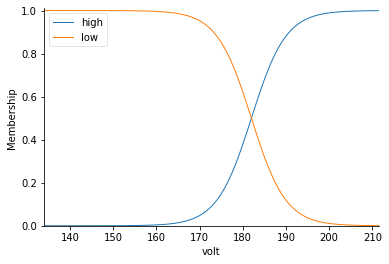

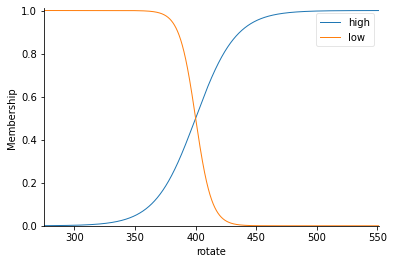

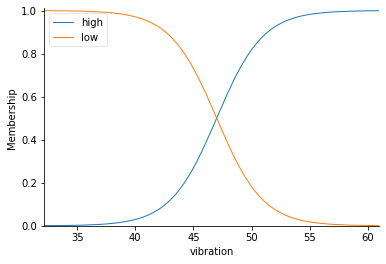

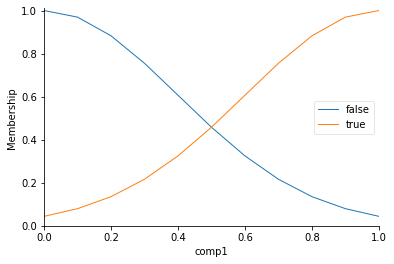

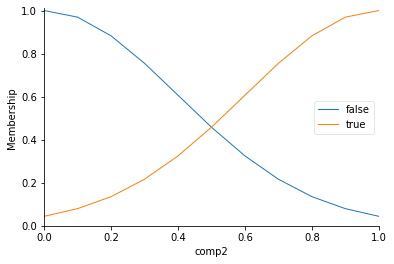

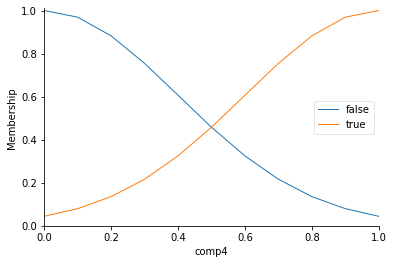

In [101]:
fuzzy_vars.visualize()

In [102]:
fuzzy_rule = FuzzyRules()
fuzzy_rule.add(
    'rule1',
    if_term=fuzzy_vars.get('volt')['high']&fuzzy_vars.get('rotate')['high']&fuzzy_vars.get('vibration')['low'],
    then_term=fuzzy_vars.get('comp1')['true']
)
fuzzy_rule.add(
    'rule2',
    if_term=fuzzy_vars.get('rotate')['low']&fuzzy_vars.get('volt')['low']&fuzzy_vars.get('vibration')['low'],
    then_term=fuzzy_vars.get('comp2')['true']
)
fuzzy_rule.add(
    'rule3',
    if_term=fuzzy_vars.get('vibration')['high']&fuzzy_vars.get('volt')['low']&fuzzy_vars.get('rotate')['high'],
    then_term=fuzzy_vars.get('comp4')['true']
)
fuzzy_rule.add(
    'rule4',
    if_term=fuzzy_vars.get('volt')['low'],
    then_term=fuzzy_vars.get('comp1')['false']
)
fuzzy_rule.add(
    'rule5',
    if_term=fuzzy_vars.get('rotate')['high'],
    then_term=fuzzy_vars.get('comp2')['false']
)
fuzzy_rule.add(
    'rule6',
    if_term=fuzzy_vars.get('vibration')['low'],
    then_term=fuzzy_vars.get('comp4')['false']
)

In [103]:
class CustomFuzzyModel(FuzzyModel):
    def process_rules_pointwise(self, input_data: dict) -> dict:
        if self.rule_engine is None:
            raise ValueError(
                (
                    "Property rule_engine is None. Please load your rule_engine "
                    "to run this method."
                )
            )

        # TODO: add preprocess of input_data here
        input_data = np.array(list(input_data.values()))
        daily_average = np.average(
            input_data.reshape((-1, 4)), axis=0
        )
        input_data = {
            "volt": daily_average[0],
            "rotate": daily_average[1],
            "vibration": daily_average[3]
        } 
        for key, value in input_data.items():
            self.rule_engine.input[key] = value
        self.rule_engine.compute()

        outputs = {}
        for cls in self.rule_engine.ctrl.consequents:
            outputs[cls.label] = round(self.rule_engine.output[cls.label], 5)
        return outputs

modeler = FuzzyModeler(model_class=CustomFuzzyModel)
ts_teacher = modeler.build_model(fuzzy_vars, fuzzy_rule)

In [104]:
predictions = ts_teacher.predict({'x': input_data['unlabeled_data']})['predictions']

array([[<AxesSubplot:title={'center':'comp1'}>,
        <AxesSubplot:title={'center':'comp2'}>],
       [<AxesSubplot:title={'center':'comp4'}>, <AxesSubplot:>]],
      dtype=object)

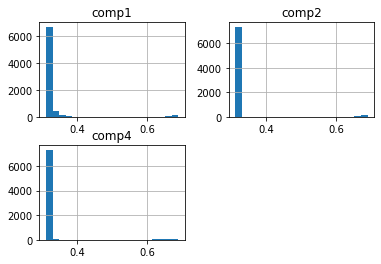

In [105]:
predictions.hist(bins=20)

In [106]:
fuzzy_thresholds = {'comp1': 0.6, 'comp2': 0.6, 'comp4': 0.6}
modeler = OracleModeler()
oracle8 = modeler.build_model(
    data=input_data, 
    teacher=ts_teacher,
    fuzzy_thresholds=fuzzy_thresholds)

test_data = {'x': input_data['labeled_data']['x_test']}
prediction = oracle8.predict(test_data)

INFO:root:Evaluated all sub models successfully.


In [107]:
oracle8.metrics

{'accuracy': {'comp1': {'teacher': 0.97632,
   'students': [0.98904, 0.9773],
   'ensemblers': 0.98943},
  'comp2': {'teacher': 0.97241,
   'students': [0.98004, 0.97241],
   'ensemblers': 0.98063},
  'comp4': {'teacher': 0.97965,
   'students': [0.97906, 0.97847],
   'ensemblers': 0.9816}},
 'precision': {'comp1': {'teacher': 0.15441,
   'students': [0.08571, 0.16031],
   'ensemblers': 0.09091},
  'comp2': {'teacher': 0.1761,
   'students': [0.20909, 0.18788],
   'ensemblers': 0.20388},
  'comp4': {'teacher': 0.16379,
   'students': [0.14783, 0.16129],
   'ensemblers': 0.16}},
 'recall': {'comp1': {'teacher': 0.77778,
   'students': [0.11111, 0.77778],
   'ensemblers': 0.11111},
  'comp2': {'teacher': 0.73684,
   'students': [0.60526, 0.81579],
   'ensemblers': 0.55263},
  'comp4': {'teacher': 0.73077,
   'students': [0.65385, 0.76923],
   'ensemblers': 0.61538}}}

In [108]:
fuzzy_thresholds = {'comp1': 0.6, 'comp2': 0.6, 'comp4': 0.6}
modeler = OracleModeler()
oracle9 = modeler.build_model(
    data=input_data, 
    teacher=ts_teacher,
    fuzzy_thresholds=fuzzy_thresholds,
    ensembler_modeler=GradBoostEnsembleModeler())

test_data = {'x': input_data['labeled_data']['x_test']}
prediction = oracle9.predict(test_data)

INFO:root:Evaluated all sub models successfully.


In [109]:
oracle9.metrics

{'accuracy': {'comp1': {'teacher': 0.97632,
   'students': [0.98885, 0.9773],
   'ensemblers': 0.96888},
  'comp2': {'teacher': 0.97241,
   'students': [0.97926, 0.97241],
   'ensemblers': 0.95656},
  'comp4': {'teacher': 0.97965,
   'students': [0.98102, 0.97847],
   'ensemblers': 0.97299}},
 'precision': {'comp1': {'teacher': 0.15441,
   'students': [0.14286, 0.16031],
   'ensemblers': 0.13736},
  'comp2': {'teacher': 0.1761,
   'students': [0.21667, 0.18788],
   'ensemblers': 0.11345},
  'comp4': {'teacher': 0.16379,
   'students': [0.18584, 0.16129],
   'ensemblers': 0.15432}},
 'recall': {'comp1': {'teacher': 0.77778,
   'students': [0.22222, 0.77778],
   'ensemblers': 0.92593},
  'comp2': {'teacher': 0.73684,
   'students': [0.68421, 0.81579],
   'ensemblers': 0.71053},
  'comp4': {'teacher': 0.73077,
   'students': [0.80769, 0.76923],
   'ensemblers': 0.96154}}}

In [110]:
fuzzy_thresholds = {'comp1': 0.6, 'comp2': 0.6, 'comp4': 0.6}
modeler = OracleModeler()
oracle10 = modeler.build_model(
    data=input_data, 
    teacher=ts_teacher,
    fuzzy_thresholds=fuzzy_thresholds,
    ensembler_modeler=GradBoostEnsembleModeler(),
    inject_x_in_ensembler=True)

test_data = {'x': input_data['labeled_data']['x_test']}
prediction = oracle10.predict(test_data)

INFO:root:Evaluated all sub models successfully.


In [111]:
oracle10.metrics

{'accuracy': {'comp1': {'teacher': 0.97632,
   'students': [0.98826, 0.9773],
   'ensemblers': 0.97221},
  'comp2': {'teacher': 0.97241,
   'students': [0.98102, 0.97241],
   'ensemblers': 0.97084},
  'comp4': {'teacher': 0.97965,
   'students': [0.97984, 0.97847],
   'ensemblers': 0.9726}},
 'precision': {'comp1': {'teacher': 0.15441,
   'students': [0.09756, 0.16031],
   'ensemblers': 0.13836},
  'comp2': {'teacher': 0.1761,
   'students': [0.21359, 0.18788],
   'ensemblers': 0.17919},
  'comp4': {'teacher': 0.16379,
   'students': [0.16522, 0.16129],
   'ensemblers': 0.15244}},
 'recall': {'comp1': {'teacher': 0.77778,
   'students': [0.14815, 0.77778],
   'ensemblers': 0.81481},
  'comp2': {'teacher': 0.73684,
   'students': [0.57895, 0.81579],
   'ensemblers': 0.81579},
  'comp4': {'teacher': 0.73077,
   'students': [0.73077, 0.76923],
   'ensemblers': 0.96154}}}

In [112]:
assert 1 == 2

AssertionError: 